In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.append('../helpers/')

import os
from pathlib import Path
import pickle
import pprint
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, cohen_kappa_score, multilabel_confusion_matrix, balanced_accuracy_score, confusion_matrix, roc_auc_score

pp = pprint.PrettyPrinter(indent=4)

from feature_selection import FeatureSelection

select_feature = FeatureSelection()


# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

Init class FS {}


In [5]:
def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

In [6]:
def compare_models(models, param_grids, X_train, y_train, X_val, y_val, scoring_metric='accuracy', cv=10):
    all_models = []
    
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=2, scoring=scoring_metric)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Store the best model and its parameters
        all_models.append({'model': best_model, 'params': best_params})
    
    # Evaluate the best models on a separate validation set
    models_report = []
    for model_info in all_models:
        model = model_info['model']
        y_pred = model.predict(X_val)

        # Accuracy score
        accuracy = accuracy_score(y_val, y_pred)
        kappa = cohen_kappa_score(y_val, y_pred)
        
        # F1 score
        f1 = f1_score(y_val, y_pred)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_val, y_pred)
        true_positives = conf_matrix[1, 1]
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        false_negatives = conf_matrix[1, 0]

        # Sensitivity (True Positive Rate or Recall)
        sensitivity = true_positives / (true_positives + false_negatives)

        # Specificity (True Negative Rate)
        specificity = true_negatives / (true_negatives + false_positives)

        # Precision
        precision = true_positives / (true_positives + false_positives)

        models_report.append({
            'model': model, 
            'best_params': model_info['params'], 
            'accuracy': accuracy, 
            'kappa': kappa,
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'precision': precision})
        
        models_report.sort(key=lambda x: x['accuracy'], reverse=True)

        plt.figure(figsize=(16, 6))
        plt.subplot(1,2,1)
        
        fpr, tpr, _ = roc_curve(y_val, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)


        # plotting cm, nevus = 0, others = 1
        cm = confusion_matrix(y_val, y_pred)
        cm_df = pd.DataFrame(cm,
                            index=['nevus', 'others'],
                            columns=['nevus', 'others'])
        
        pprint_objects(cm)
        
        plt.subplot(1,2,2)
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.show()
    
    # return best_model, best_score, best_params, all_models
    return models_report
    

In [7]:
ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

In [8]:
experiment              = 4

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None, on_bad_lines='skip')
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None, on_bad_lines='skip')

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None, on_bad_lines='skip')
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None, on_bad_lines='skip')

In [9]:
train_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,157.238011,171.0,0.011527,3.817046,0.037923,5.342307,14.526250,125.662256,138.0,0.010243,...,0.017826,0.016285,0.018685,0.018685,0.020074,0.014141,0.007319,0.073348,0.347937,0.0
1,201.937144,210.0,0.011170,3.019431,0.035846,5.016944,8.244900,202.228206,205.0,0.012582,...,0.023696,0.018056,0.024837,0.016727,0.018650,0.008077,0.005560,0.079812,0.259552,0.0
2,149.933744,160.0,0.013459,4.990924,0.050281,5.082027,26.411318,140.707456,149.0,0.011807,...,0.015440,0.013021,0.018877,0.019531,0.023338,0.015481,0.008381,0.089910,0.400306,0.0
3,180.062478,188.0,0.011649,4.138790,0.038645,5.263665,17.426843,159.837622,178.0,0.009461,...,0.018000,0.016330,0.018767,0.017930,0.019574,0.013581,0.008611,0.073663,0.340263,0.0
4,201.379756,205.0,0.012416,4.031809,0.043372,5.068116,15.864496,142.026344,150.0,0.008790,...,0.013619,0.015311,0.017493,0.019781,0.023619,0.019993,0.012359,0.087644,0.432200,0.0


In [10]:
print(train_nevus_df.shape)

(7725, 279)


In [11]:
train_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,143.418712,174.0,0.005047,1.647879,0.010427,6.862629,2.397556,133.337806,157.0,0.004276,...,0.007885,0.008702,0.010465,0.013727,0.020567,0.022927,0.016177,0.081679,0.478398,1.0
1,177.313831,178.0,0.012857,4.181146,0.046224,4.948662,17.335125,143.204200,148.0,0.008623,...,0.014958,0.015119,0.016079,0.017165,0.019433,0.016565,0.011448,0.065283,0.367760,1.0
2,142.869469,144.0,0.016490,4.991996,0.073516,4.156845,24.959298,120.942394,122.0,0.011405,...,0.005950,0.006917,0.008635,0.012485,0.021433,0.026533,0.019844,0.092346,0.538815,1.0
3,203.101750,212.0,0.010098,2.993415,0.030013,5.361549,8.389612,162.374181,183.0,0.005913,...,0.020852,0.012883,0.016331,0.008248,0.009779,0.003494,0.002002,0.046194,0.136567,1.0
4,130.405944,1.0,0.008476,3.704305,0.022298,6.297036,14.614478,86.601575,1.0,0.007339,...,0.014727,0.012560,0.016387,0.014988,0.017108,0.012425,0.007321,0.091177,0.312458,1.0


In [12]:
print(train_others_df.shape)

(7470, 279)


In [13]:
val_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,179.957963,196.0,0.010615,3.289989,0.032755,5.550535,9.696586,177.849469,190.0,0.012221,...,0.015652,0.014783,0.015896,0.017254,0.020160,0.016035,0.009071,0.069790,0.385342,0.0
1,214.950933,231.0,0.008005,2.540727,0.020311,5.943256,6.297179,112.850000,148.0,0.005946,...,0.014693,0.015052,0.017415,0.018481,0.021189,0.018237,0.010619,0.075759,0.398167,0.0
2,198.330887,204.0,0.009431,2.845644,0.026678,5.660727,7.344996,195.295969,205.0,0.007567,...,0.015067,0.013090,0.016567,0.016644,0.019877,0.014017,0.009719,0.074842,0.349240,0.0
3,181.317969,222.0,0.010014,4.924824,0.029576,6.188504,25.821507,177.972475,226.0,0.008768,...,0.014617,0.011673,0.019523,0.016050,0.019467,0.012125,0.007575,0.090821,0.337288,0.0
4,218.419756,233.0,0.008792,2.812908,0.023697,5.951481,6.667646,127.764156,147.0,0.008216,...,0.015430,0.016370,0.018485,0.020096,0.022307,0.018070,0.010526,0.079141,0.393970,0.0


In [14]:
print(val_nevus_df.shape)

(1931, 279)


In [15]:
val_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,116.435262,1.0,0.007016,2.545273,0.016508,6.463351,6.527959,104.308475,1.0,0.005535,...,0.009160,0.008281,0.009402,0.011321,0.014533,0.012165,0.006221,0.077381,0.331912,1.0
1,172.058600,178.0,0.008495,2.284776,0.022379,5.727040,3.955654,130.444322,129.0,0.006868,...,0.018393,0.016711,0.016604,0.015752,0.015133,0.010811,0.006707,0.049419,0.249822,1.0
2,214.548919,220.0,0.010418,3.310539,0.031692,5.513930,10.273278,163.268256,173.0,0.005883,...,0.022350,0.017319,0.020460,0.013996,0.014640,0.006188,0.004035,0.055819,0.200540,1.0
3,195.090413,210.0,0.008363,2.197036,0.021812,5.727158,3.700458,156.711038,179.0,0.006994,...,0.019563,0.018921,0.019071,0.017825,0.017877,0.011727,0.007088,0.063573,0.286894,1.0
4,159.246500,192.0,0.007095,2.714642,0.016793,6.542190,6.763010,148.376925,185.0,0.005194,...,0.014331,0.012035,0.014646,0.015773,0.018304,0.012823,0.006744,0.071442,0.349892,1.0


In [16]:
print(val_others_df.shape)

(1865, 279)


In [17]:
# Concatenate the 'nevus' and 'others' dataframes
train_features = pd.concat([train_nevus_df, train_others_df], ignore_index=True)
val_features = pd.concat([val_nevus_df, val_others_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)


In [18]:
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

X_val.head()


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
298,212.652089,219.0,0.009457,2.665059,0.026803,5.532736,5.940784,119.166433,130.0,0.007473,...,0.014026,0.016085,0.016507,0.017385,0.018948,0.020730,0.016674,0.009863,0.074107,0.383415
3078,140.089919,144.0,0.014141,4.364045,0.055098,4.548942,19.329565,137.560350,143.0,0.013271,...,0.012302,0.016102,0.014113,0.019015,0.019960,0.023742,0.015706,0.008215,0.085862,0.402779
1361,231.208733,233.0,0.012122,3.633604,0.041522,4.928246,12.652456,146.975678,152.0,0.012379,...,0.012119,0.014759,0.016548,0.018219,0.020744,0.022841,0.018789,0.011419,0.084244,0.417467
2711,186.715878,197.0,0.008878,2.435293,0.024086,5.627522,4.876680,163.850789,175.0,0.007880,...,0.016296,0.019978,0.018000,0.019419,0.019122,0.018741,0.011352,0.006978,0.068337,0.319848
2416,205.468500,210.0,0.008173,2.031932,0.021007,5.772153,2.954551,174.191111,181.0,0.007760,...,0.014196,0.016559,0.016563,0.017363,0.018485,0.019930,0.015433,0.008863,0.071107,0.369211


In [19]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [20]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [21]:
print(X_train_normalized.shape, y_train_encoded.shape, X_val_normalized.shape, y_val_encoded.shape)

(15195, 278) (15195,) (3796, 278) (3796,)


In [22]:
X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)
X_train_normalized

,0,1,2,4,5,9,10,11,12,16,...,264,265,266,267,272,273,274,275,276,277
0,0.710341,0.524124,0.486763,0.294037,-0.176257,-0.106707,0.629025,-0.231031,0.522873,-0.301301,...,2.017127,2.075348,2.238380,1.905105,-1.716545,-1.740642,-2.136828,-1.805050,-0.916389,-2.161680
1,-0.689763,-0.208064,-0.622911,-0.604195,0.197348,-0.614919,-1.030404,-0.616179,0.203885,-0.991778,...,-1.846171,-1.809442,-1.681014,-1.691096,1.373702,1.964484,1.543964,1.339291,1.700337,1.286000
2,0.377737,0.196566,0.532010,0.338160,-0.784911,0.109627,-0.307511,-0.044996,-0.438307,0.529021,...,0.412458,0.474552,0.415499,0.861970,0.310844,-0.541963,-0.424556,-0.415314,-0.551476,-0.342822
3,-0.476263,0.389248,-1.674190,-1.129205,1.845407,-1.856198,-2.095830,-1.250860,1.964529,-2.024165,...,1.606327,1.392723,0.892792,1.146730,-1.516381,-2.147844,-0.962596,-0.368456,-1.688512,-1.424114
4,0.408745,0.292907,0.057857,-0.095037,-0.161669,0.577241,0.401680,0.402197,-0.586513,0.675917,...,-0.547379,-0.479828,-0.387313,-0.325700,0.535590,0.501397,0.593768,0.987965,0.021846,0.310747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15190,1.024603,0.639733,1.354952,1.243176,-1.239340,0.563684,0.423614,0.388365,-0.568074,0.652987,...,-1.358902,0.186551,2.725339,-1.234335,-1.116053,2.870439,-2.261147,-1.694242,5.460186,-1.060395
15191,-1.199237,-0.651231,0.798001,0.609424,-0.726204,1.396223,1.039476,1.333898,-1.324528,1.579573,...,-0.215420,0.002698,0.337807,0.731264,1.353412,0.636220,-0.345326,-0.460507,0.279046,-0.003455
15192,-0.853495,-0.554890,1.250756,1.117844,-1.330004,1.548136,1.077535,1.527503,-1.497690,1.064994,...,-2.434095,-2.541806,-2.423522,-2.873234,-1.497945,1.395358,2.988414,3.397714,1.675418,2.715616
15193,-0.301218,-0.188796,1.079525,0.918644,-1.082544,0.959614,1.154596,0.813671,-0.763359,0.775324,...,0.872143,1.108772,1.423268,1.583423,-0.486689,-0.712010,-0.892435,-0.830157,-0.129119,-0.589661


In [23]:
selected_feature_indices

array([  0,   1,   2,   4,   5,   9,  10,  11,  12,  16,  17,  18,  19,
        23,  24,  25,  26,  27,  28,  29,  30,  32,  33,  35,  36,  37,
        39,  40,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,
        54,  55,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        70,  71,  80,  83,  86,  87,  88,  90,  93,  94,  95,  96,  97,
        98, 100, 101, 102, 104, 105, 106, 115, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 129, 132, 136, 139, 140, 141, 142, 145, 149,
       150, 151, 152, 156, 157, 158, 159, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 175, 176, 177, 180, 182, 183, 184, 185,
       186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 223, 224, 225, 234, 235,
       237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       272, 273, 274, 275, 276, 277], dtype=int64)

In [24]:
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]
X_val_normalized

,0,1,2,4,5,9,10,11,12,16,...,264,265,266,267,272,273,274,275,276,277
0,0.932686,0.601197,-0.367194,-0.428535,0.093095,-0.365834,-0.364341,-0.436505,0.191786,-0.652664,...,-0.420286,-0.229036,-0.300742,0.125079,0.761896,0.333779,0.398610,0.173344,-0.041378,0.381740
1,-1.387935,-0.843912,0.881643,0.698920,-1.038604,1.716244,1.072686,1.749329,-1.742017,2.844501,...,-0.287265,-0.481495,-0.194333,-0.168558,1.188463,1.321570,0.180673,-0.342384,0.641163,0.649160
2,1.526149,0.870950,0.343229,0.157956,-0.602275,1.395741,1.132931,1.333293,-1.228546,0.857317,...,-1.130996,-0.890699,-0.959270,-0.661212,1.518850,1.026113,0.874828,0.660031,0.547213,0.851994
3,0.103216,0.177298,-0.521527,-0.536796,0.202131,-0.219792,-0.544467,-0.323030,-0.082182,-0.321277,...,0.540816,0.772605,0.940841,1.253057,0.835250,-0.318473,-0.799860,-0.729343,-0.376426,-0.496112
4,0.702947,0.427784,-0.709589,-0.659478,0.368505,-0.263105,-0.538476,-0.357311,-0.039471,-0.509428,...,-0.189495,-0.062096,-0.231190,0.296952,0.566804,0.071421,0.119217,-0.139525,-0.215569,0.185588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,-0.476363,-0.381477,-0.418905,-0.465571,0.222348,-0.205404,-0.217525,-0.311524,0.174506,0.177381,...,-0.434829,-0.402837,-0.423569,-0.122952,1.222311,0.805052,0.383598,0.052832,0.334529,0.285377
3792,-0.254519,-0.092455,0.827948,0.641236,-0.690768,0.666532,0.889952,0.494596,-0.445862,0.229248,...,-0.993628,-1.012331,-1.029654,-1.062398,0.256121,1.377594,1.251696,0.715507,0.782571,1.462105
3793,0.412156,0.350711,0.040152,-0.109963,-0.355506,0.063847,0.663880,-0.085464,-0.000051,-0.365403,...,-0.218265,-0.384161,-0.390781,-0.150612,-0.131915,0.330894,0.544717,0.165378,-0.071082,0.726352
3794,0.417418,0.408516,-0.597652,-0.587679,0.325465,-0.331378,-0.510749,-0.410275,0.144808,-0.266466,...,0.094409,0.210039,0.275654,0.631434,1.298787,0.044699,-0.152670,-0.124461,-0.632980,-0.371362


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  14.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  10.8s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  10.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  11.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  11.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  12.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  11.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  13.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  12.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  16.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  12.4s
[CV] END ...................C=0.1, gamma=0.01, k

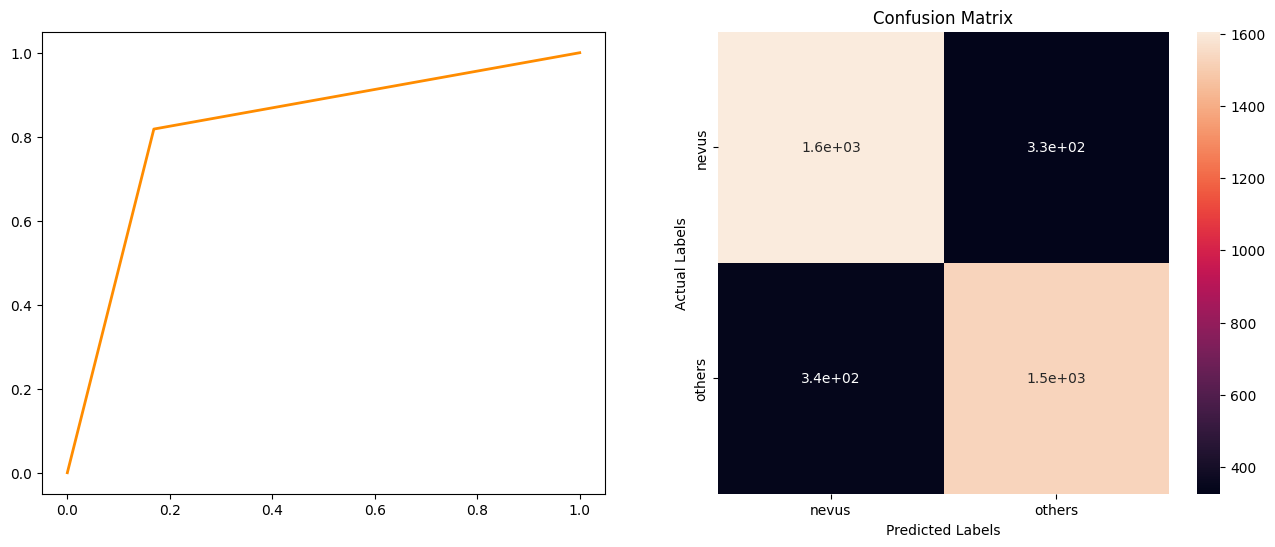

Model Report: [{'model': SVC(C=10, gamma=0.01), 'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, 'accuracy': 0.8248155953635405, 'kappa': 0.6494834882303966, 'f1': 0.8210922787193974, 'sensitivity': 0.8182305630026809, 'specificity': 0.8311755567063698, 'precision': 0.8239740820734341}]


In [25]:
# Define the list of models and their respective hyperparameter grids
models = [
    SVC(),
    # LogisticRegression(), 
    # KNeighborsClassifier(),
    # RandomForestClassifier(),
    # LinearDiscriminantAnalysis(),
    # XGBClassifier()
    ] 
        

param_grids = [
    {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]},
    # {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']},
    # {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
    # {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, # still takes a lot of time
    # {'solver': ['svd', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},
    # {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)

# Save the best model to a file
# best_model_filename = ROOT_PATH/'best_model.pkl'
# with open(best_model_filename, 'wb') as file:
#     pickle.dump(best_model, file)

print("Model Report:", models_report)
# print("Best Score:", best_score)
# print("Best Params:", best_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ..........C=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l

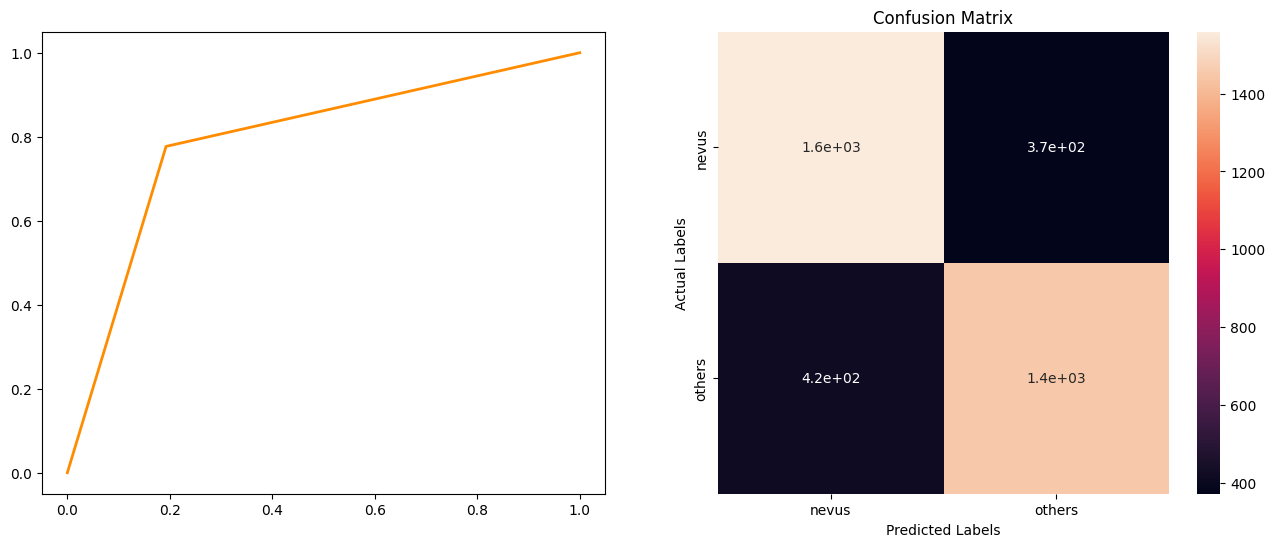

Model Report: [{'model': LogisticRegression(C=0.1, penalty=None, solver='newton-cholesky'), 'best_params': {'C': 0.1, 'penalty': None, 'solver': 'newton-cholesky'}, 'accuracy': 0.7924130663856691, 'kappa': 0.5845330780643596, 'f1': 0.786218122626153, 'sensitivity': 0.7769436997319035, 'specificity': 0.8073537027446919, 'precision': 0.7957166392092258}]


In [26]:
# Define the list of models and their respective hyperparameter grids
models = [
    LogisticRegression()
    ] 
        

param_grids = [
    {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']},
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)


print("Model Report:", models_report)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform; total time=  10.7s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform; total time=   8.1s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform; total time=   7.1s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform; total time=   7.1s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform; total time=   9.4s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance; total time=   7.5s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance; total time=   8.0s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance; total time=   8.9s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance; total time=   8.2s
[CV] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance; total time=   8.4s
[CV] END algorithm=ball_tree, n_neighbors=3, p=2, weights=uniform; total 

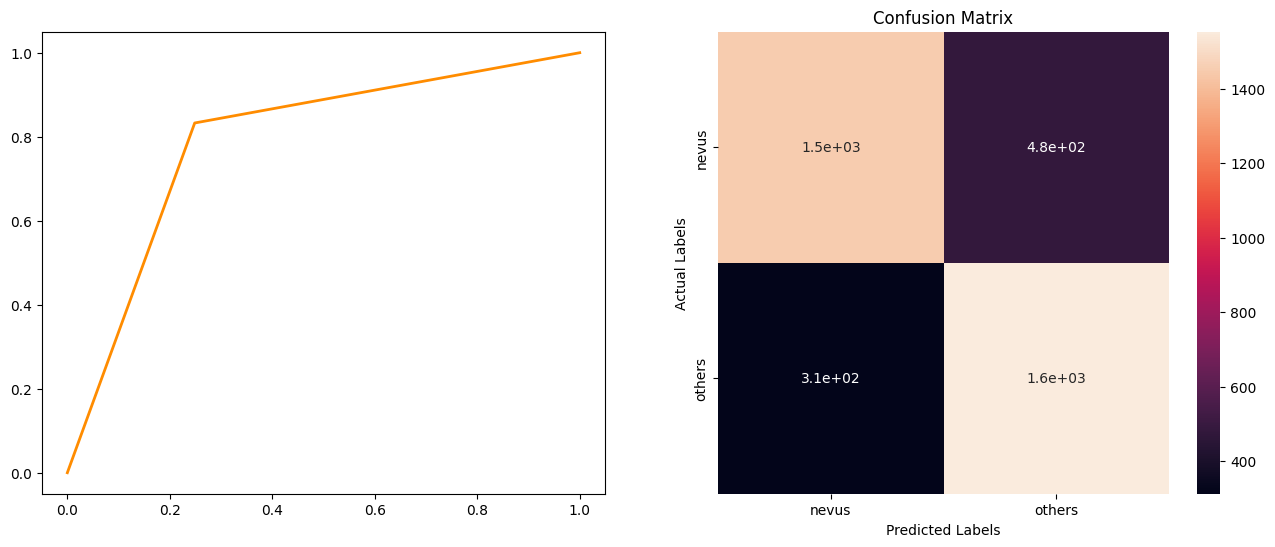

Model Report: [{'model': KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance'), 'best_params': {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}, 'accuracy': 0.7913593256059009, 'kappa': 0.5832340548937455, 'f1': 0.796818881477681, 'sensitivity': 0.8327077747989277, 'specificity': 0.7514241325737959, 'precision': 0.763895720609936}]


In [27]:
# Define the list of models and their respective hyperparameter grids
models = [
    KNeighborsClassifier()
    ] 
        
param_grids = [
    {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)

print("Model Report:", models_report)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END max_depth=3, min_samples_leaf=1, 

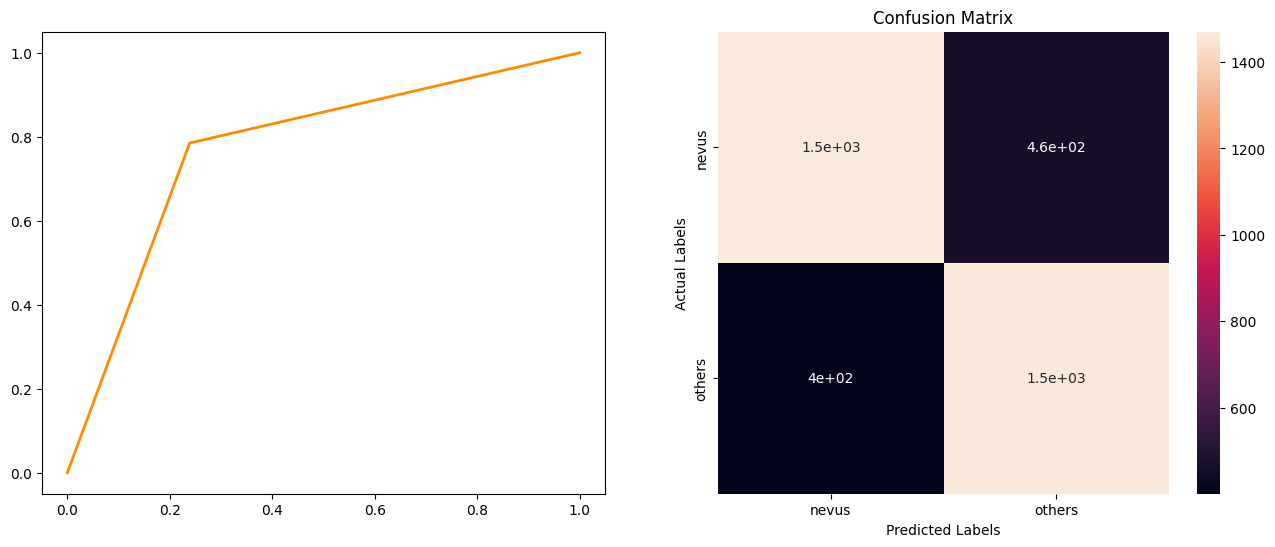

Model Report: [{'model': RandomForestClassifier(max_depth=9), 'best_params': {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 'accuracy': 0.7729188619599578, 'kappa': 0.5459500262953769, 'f1': 0.7725593667546173, 'sensitivity': 0.7849865951742627, 'specificity': 0.7612635939927499, 'precision': 0.7605194805194805}]


In [28]:
# Define the list of models and their respective hyperparameter grids
models = [
    RandomForestClassifier()
    ] 
        

param_grids = [
    {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, # still takes a lot of time
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)

print("Model Report:", models_report)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .........................shrinkage=None, solver=svd; total time=   0.2s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.2s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.1s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.1s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.2s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.1s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.0s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.1s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.1s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.1s
[CV] END .........................shrinkage=auto, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=auto

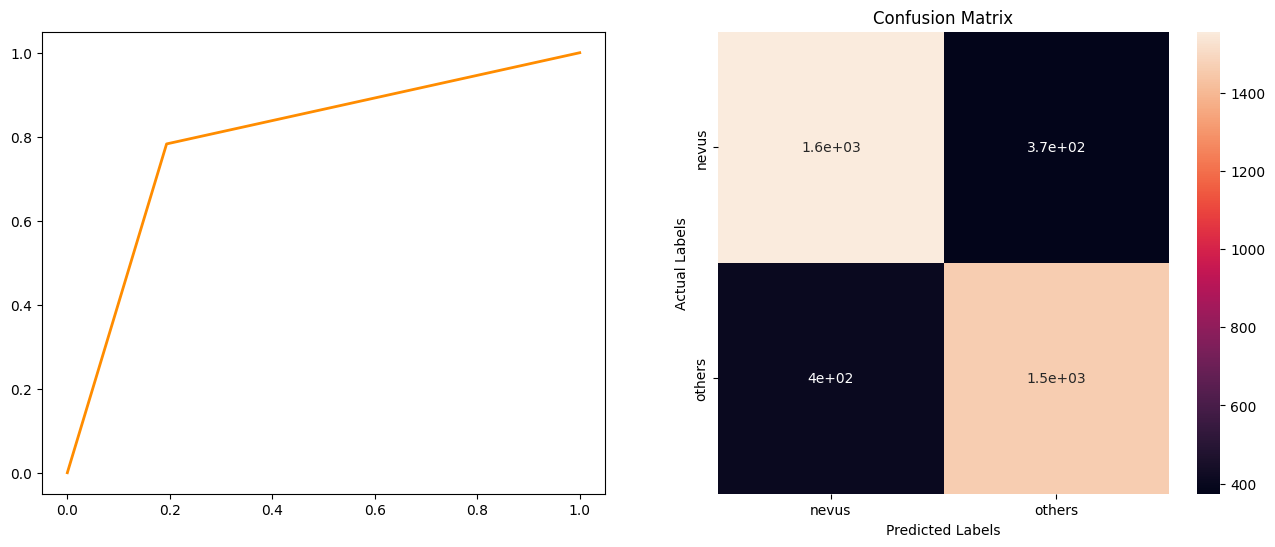

Model Report: [{'model': LinearDiscriminantAnalysis(), 'best_params': {'shrinkage': None, 'solver': 'svd'}, 'accuracy': 0.7947839831401475, 'kappa': 0.5893271990160798, 'f1': 0.7894025412273586, 'sensitivity': 0.7828418230563002, 'specificity': 0.8063179699637494, 'precision': 0.7960741548527808}]


In [29]:
# Define the list of models and their respective hyperparameter grids
models = [
    LinearDiscriminantAnalysis(),
    ] 
        

param_grids = [
    {'solver': ['svd', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)

print("Model Report:", models_report)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample

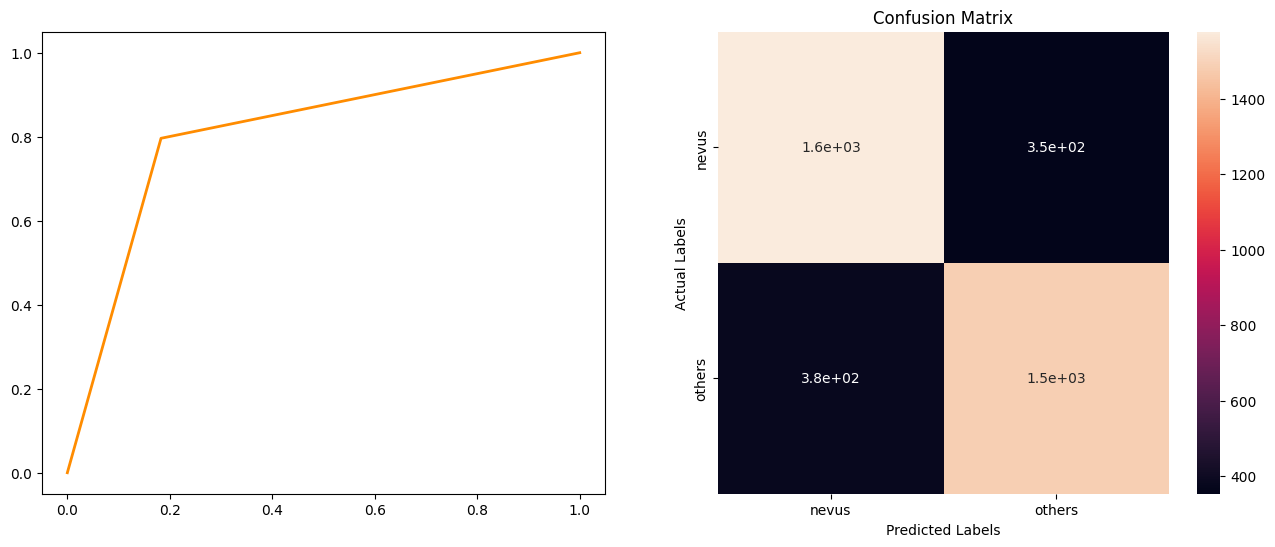

Model Report: [{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'best_params': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}, 'accuracy': 0.8069020021074815, 'kappa': 0.6135916214312536, 'f1': 0.8020523899540912, 'sensitivity': 0

In [30]:
# Define the list of models and their respective hyperparameter grids
models = [
    XGBClassifier()
    ] 
        

param_grids = [
    {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
]

# Call the function to compare models and get the best one
models_report = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy', cv=5)

print("Model Report:", models_report)

In [31]:
# models_report

In [23]:
best_model = models_report[0]['model']
best_model

SVC(C=10, gamma=0.01)

In [24]:
# = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]}
#svc = SVC()

# Create a GridSearchCV object with a classifier and the parameter grid
#grid_search = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, verbose=10)

# Fit the grid search to your training data
#grid_search.fit(X_train_normalized, y_train_encoded)

# Get the best hyperparameters and the best model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

In [25]:
# best_params

In [26]:
y_pred = best_model.predict(X_val_normalized)
print(y_pred)

[0 0 0 ... 0 1 1]


### Model evaluation

In [33]:
fpr, tpr, thresholds = roc_curve(y_val_encoded, y_pred)
roc_auc = auc(fpr, tpr)

print(len(thresholds))

3


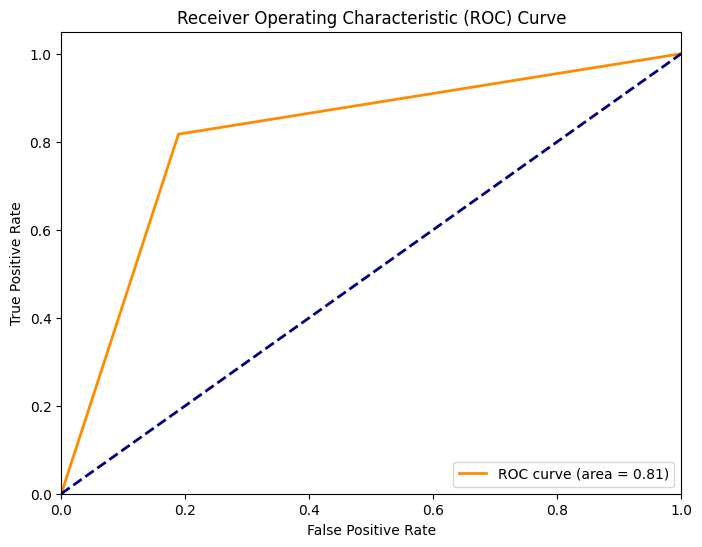

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7763435194942044


## Predicting in the test set

In [92]:
# best_model_filename = ROOT_PATH/'best_model.pkl'
# # Load the saved model from a file
# with open(best_model_filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# # Now you can use loaded_model to make predictions on new samples
# X_pred = loaded_model.predict(X_test)